## 0. Dependencies

If you have not installed openCV, run the following code

In [ ]:
# ! pip install opencv-python


Data is from UTKFace
https://susanqq.github.io/UTKFace/

"crop_part_1.tar.gz" in "Aligned&Cropped Faces" was used

If you use Google Colab, run the code to monte at the drive.

In [ ]:
from google.colab import drive

drive.mount("/content/drive")


Mounted at /content/drive


Load the packages

In [ ]:
import cv2
import os
import time
import random
import numpy as np
import pandas as pd


In [ ]:
from sklearn.model_selection import train_test_split
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import time
import matplotlib
from sklearn import metrics
from sklearn.metrics import precision_recall_curve


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## 1. Subsetting and Loading

Due to the limitation of time and RAM, subset could be used. Specify $n$ to get n random samples from the whole dataset.

In [ ]:
# set a seed
random.seed(328)

# define dir
data_dir = "/content/drive/My Drive/crop_part1"

# random sampling from 9780 samples
n = 9780
fnames_subset = random.sample(os.listdir(data_dir), n)


Constructing our response variable(gender) and variable(race). 

In [ ]:
y = []  # 0 (male) or 1 (female)
y_race = []
for fname in fnames_subset:
    temp = fname.split("_")
    y.append(int(temp[1]))
    if temp[2] in ("0", "1"):
        y_race.append(int(temp[2]))
    elif temp[2] in ("2", "3"):
        y_race.append(2)
    else:
        y_race.append(3)
    pass


Storing the values of the pixels into a 4D array. (Number of samples, Red Channel, Green Channel, Blue Channel)

In [ ]:
# X: flattened version
# X_origin_dict: original version; key: index, value: 3-D np array
X_rgb = list()
X_origin_dict = dict()
for i, fname in enumerate(fnames_subset):
    # construct dir
    dir = data_dir + "/" + fname

    # read the data
    dat = cv2.imread(dir)

    # convert to rgb
    dat = cv2.cvtColor(dat, cv2.COLOR_BGR2RGB)

    # store the original data
    X_origin_dict[i] = dat

    # store the data
    X_rgb.append(dat)


## 2. Preprocessing

### Data Cleaning

In EDA, we know there is one sample of an unknown label, delete that sample.

In [ ]:
find = False
for i, lab in enumerate(y):
    if lab == 3:
        find = True
        delete = i

if find:
    y.pop(delete)
    y_race.pop(delete)
    X_rgb.pop(delete)


In [ ]:
# convert to np array
y = np.array(y)
y_race = np.array(y_race)
X_rgb = np.array(X_rgb)
print("The shape of the X_rgb is:", X_rgb.shape)


The shape of the X_rgb is: (9779, 200, 200, 3)


### Subsetting for the expriments

In [ ]:
df = pd.DataFrame(
    {"y": y, "y_race": y_race, "img": list(X_rgb)}, columns=["y", "y_race", "img"]
)


In [ ]:
df.head()


,y,y_race,img
0,0,3,"[[[150, 121, 107], [150, 121, 107], [149, 120,..."
1,0,3,"[[[210, 203, 197], [228, 221, 215], [245, 238,..."
2,0,3,"[[[31, 27, 16], [30, 26, 15], [29, 25, 14], [2..."
3,1,3,"[[[27, 17, 7], [24, 14, 4], [21, 12, 3], [19, ..."
4,0,3,"[[[16, 16, 16], [17, 17, 17], [18, 18, 18], [1..."


First, train(80%), validation(10%), test(10%) split is performed.

In [ ]:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(
    df, y, test_size=0.1, random_state=329
)

X_train_exp, X_val_exp, y_train_exp, y_val_exp = train_test_split(
    X_train_exp, y_train_exp, test_size=(0.1 / 0.9), random_state=525
)


In [ ]:
X_train_exp.head(1)


,y,y_race,img
140,0,3,"[[[42, 42, 42], [34, 34, 34], [29, 29, 29], [3..."


In [ ]:
X_train_exp["y_race"].unique()


array([0, 1, 3, 2])

### Subsetting for experiments

#### Subsetting for race

Exclude one subgroup in a time both in train and validation sets. Detailed explanations are in slides and the report.

In [ ]:
# Data Structure:
# "data_exp_r": dict
#     key: the subgroup num to exclude, value: dict
#           key:["train", "val", "test"], value: dict
#               key:["X", "y"], value: data np.array


In [ ]:
# init the dict
data_exp_r = {}
for _ in range(4):
    data_exp_r[_] = {}
    data_exp_r[_]["train"] = {}
    data_exp_r[_]["val"] = {}
    data_exp_r[_]["test"] = {}

# exclude one subgroup at a time
for r in range(4):
    X_train0 = X_train_exp.loc[(X_train_exp["y_race"] != r)].copy()
    X_train_ex0 = X_train0["img"]
    y_train_ex0 = X_train0["y"]
    X_val0 = X_val_exp.loc[(X_val_exp["y_race"] != r)].copy()
    X_val_ex0 = X_val0["img"]
    y_val_ex0 = X_val0["y"]
    temp = []
    for _ in X_train_ex0:
        temp.append(np.array(_))
    data_exp_r[r]["train"]["X"] = np.array(temp)
    data_exp_r[r]["train"]["y"] = np.array(y_train_ex0)
    temp = []
    for _ in X_val_ex0:
        temp.append(np.array(_))
    data_exp_r[r]["val"]["X"] = np.array(temp)
    data_exp_r[r]["val"]["y"] = np.array(y_val_ex0)

# for test set, we maintain the original ratio of subgroups
X_temp, y_temp = [], []
for i in range(4):
    X_test0 = X_test_exp.loc[(X_test_exp["y_race"] == i)].copy()
    X_test_r0 = X_test0["img"]
    y_test_r0 = X_test0["y"]
    temp = []
    for _ in X_test_r0:
        temp.append(np.array(_))
    X_temp.append(np.array(temp))
    y_temp.append(np.array(y_test_r0))

for r in range(4):
    data_exp_r[r]["test"]["X"] = X_temp
    data_exp_r[r]["test"]["y"] = y_temp


In [ ]:
type(data_exp_r[r]["train"]["X"])


numpy.ndarray

#### Subsetting for gender

Constructing subsets containing imbalanced ratio of labels. Specifically, 80% Male + 20% Female, 20% Female + 80% Male both for training and validation datasets.

In [ ]:
# Data Structure:
# "data_exp_g": dict
#     key: ["0", "1"] for different cases, value: dict
#           key:["train", "val", "test"], value: dict
#               key:["X", "y"], value: data np.array


In [ ]:
# init the data structure
data_exp_g = {}

for _ in range(2):
    data_exp_g[_] = {}
    data_exp_g[_]["train"] = {}
    data_exp_g[_]["val"] = {}
    data_exp_g[_]["test"] = {}

# construct 80% and 20% in both train and validation sets
for g in range(2):
    X_train0 = X_train_exp.loc[(X_train_exp["y"] == g)].copy()

    X_train_ex0 = X_train0["img"]
    y_train_ex0 = X_train0["y"]

    X_train1 = X_train_exp.loc[(X_train_exp["y"] != g)].copy()
    X_train_ex1 = X_train1["img"]
    y_train_ex1 = X_train1["y"]

    target = int(X_train_ex0.shape[0] * 0.25)

    X_slice = X_train_ex1[:target]
    y_slice = y_train_ex1[:target]

    X_exp_g = pd.concat([X_train_ex0, X_slice])
    y_exp_g = pd.concat([y_train_ex0, y_slice])
    temp = []
    for _ in X_exp_g:
        temp.append(np.array(_))
    temp = np.array(temp)
    data_exp_g[g]["train"]["X"] = temp
    data_exp_g[g]["train"]["y"] = y_exp_g

    # validation sets
    X_val0 = X_val_exp.loc[(X_val_exp["y"] == g)].copy()
    X_val_ex0 = X_val0["img"]
    y_val_ex0 = X_val0["y"]

    X_val1 = X_val_exp.loc[(X_val_exp["y"] != g)].copy()
    X_val_ex1 = X_val1["img"]
    y_val_ex1 = X_val1["y"]

    # 80% 20% split
    target = int(X_val_ex0.shape[0] * 0.25)

    X_slice = X_val_ex1[:target]
    y_slice = y_val_ex1[:target]

    X_exp_g = pd.concat([X_val_ex0, X_slice])
    y_exp_g = pd.concat([y_val_ex0, y_slice])

    temp = []
    for _ in X_exp_g:
        temp.append(np.array(_))
    temp = np.array(temp)
    data_exp_g[g]["val"]["X"] = temp
    data_exp_g[g]["val"]["y"] = y_exp_g

# for test set, we maintain the original ratio of subgroups
for g in range(2):
    X_temp = X_test_exp["img"]
    y_temp = X_test_exp["y"]
    temp = []
    for _ in X_temp:
        temp.append(np.array(_))
    temp = np.array(temp)
    data_exp_g[g]["test"]["X"] = temp
    data_exp_g[g]["test"]["y"] = np.array(y_temp)


## 3. Modeling

Train, validation, test split. Train: 80%, validation: 10%, test: 10%

In [ ]:
X_rgb_train, X_rgb_test, y_train, y_test = train_test_split(
    X_rgb, y, test_size=0.1, random_state=329
)

X_rgb_train, X_rgb_val, y_train, y_val = train_test_split(
    X_rgb_train, y_train, test_size=(0.1 / 0.9), random_state=525
)


Transfer Learning

The workflow and code are learned from the tutorial of transfer learning & fine-tuning in Keras
https://keras.io/guides/transfer_learning/

Transfer into TSDS object (Tansorflow Dataset Object)

In [ ]:
X_rgb_train.shape


(800, 200, 200, 3)

In [ ]:
train_tfds = tf.data.Dataset.from_tensor_slices(
    (tf.convert_to_tensor(X_rgb_train), tf.convert_to_tensor(y_train))
)
val_tfds = tf.data.Dataset.from_tensor_slices(
    (tf.convert_to_tensor(X_rgb_val), tf.convert_to_tensor(y_val))
)
test_tfds = tf.data.Dataset.from_tensor_slices(
    (tf.convert_to_tensor(X_rgb_test), tf.convert_to_tensor(y_test))
)


Prefetch and memory cache to optimize the speed.

In [ ]:
train_tfds = train_tfds.cache().batch(32).prefetch(buffer_size=10)
val_tfds = val_tfds.cache().batch(32).prefetch(buffer_size=10)
test_tfds = test_tfds.cache().batch(32).prefetch(buffer_size=10)


Data Augmumentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomRotation(0.1),
    ]
)


Training and evaluation functions

In [ ]:
def buiding_and_tuning_model(
    train_tfds, val_tfds, dp, epochs_top=20, epochs_finetuning=10
):
    """Constructing the model, train, and fine-tuning the model

    Args:
        train_tfds (tfds): training dataset
        val_tfds (tfds): validation dataset
        dp (float): the dropout rate
        epochs_top (int, optional): The number of epochs for training. Defaults to 20.
        epochs_finetuning (int, optional): The number of epochs for fine-tuning. Defaults to 10.

    Returns:
        model object: trained model
    """
    pretrained_model = keras.applications.ResNet101V2(
        weights="imagenet",
        input_shape=(200, 200, 3),
        include_top=False,
    )

    pretrained_model.trainable = False

    # input
    input_tensor = keras.Input(shape=(200, 200, 3))
    x_aug = data_augmentation(input_tensor)
    scale_layer = keras.layers.Rescaling(scale=(1 / (255 / 2)), offset=-1)
    x_scaled = scale_layer(x_aug)

    # base pre-trained model
    x_pretrained = pretrained_model(x_scaled, training=False)

    # pooling, dropout, fully-connected layer
    x = keras.layers.GlobalAveragePooling2D()(x_pretrained)
    x = keras.layers.Dropout(dp)(x)
    out_proba = keras.layers.Dense(1)(x)
    model = keras.Model(input_tensor, out_proba)

    # conpile the model for training
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy()],
    )

    model.fit(train_tfds, epochs=epochs_top, validation_data=val_tfds)

    # fine-tuning the model
    pretrained_model.trainable = True
    model.compile(
        optimizer=keras.optimizers.Adam(1e-5),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy()],
    )

    model.fit(train_tfds, epochs=epochs_finetuning, validation_data=val_tfds)

    return model


In [ ]:
def model_evl(model, X_test, y_test, verbose):
    """Evaluating the model on the test set

    Args:
        model (model): Trained model
        X_test (tfds): Test dataset
        y_test (np.array): True labels for test set
        verbose (bool): Print the AUC and AP or not

    Returns:
        tuple: output of the model, auc, ap
    """
    # evaluate on test set
    y_test_prob = model.predict(X_test)

    # calculating the auc
    auc_model = metrics.roc_auc_score(y_test, y_test_prob)
    if verbose:
        print("The AUC is {:.5f}".format(auc_model))

    ap_model = metrics.average_precision_score(y_test, y_test_prob)
    if verbose:
        print("The AP is {:.5f}".format(ap_model))

    return y_test_prob, auc_model, ap_model


For ResNet101V2, the model converges via 20 training epochs. Different dropout rates for different regularization degrees are tuned manually for saving time.

First round, dropout = [0.1, 0.2, 0.3, 0.4, 0.5] were validated. dropout=0.1 was selected since it achieve the best AUC and AP.

In [ ]:
dropout = [0.1, 0.2, 0.3, 0.4, 0.5]
auc, ap = [], []


In [ ]:
for dp in dropout:
    model = buiding_and_tuning_model(dp)

    # evaluate on test set
    y_test_prob = model.predict(X_rgb_test)

    # calculating the auc
    auc_model = metrics.roc_auc_score(y_test, y_test_prob)
    # print("The AUC is {:.5f}".format(auc_model))

    ap_model = metrics.average_precision_score(y_test, y_test_prob)
    # print("The AP is {:.5f}".format(ap_model))

    auc.append(auc_model)
    ap.append(ap_model)


In [ ]:
ind, max_auc = 0, 0
for i, a in enumerate(auc):
    if max_auc < a:
        max_auc = a
        ind = i
print("Dropout:", dropout[ind])
print("The AUC is {:.5f}".format(auc_model))
print("The AP is {:.5f}".format(ap_model))

ind, max_ap = 0, 0
for i, a in enumerate(ap):
    if max_auc < a:
        max_auc = a
        ind = i
print("Dropout:", dropout[ind])
print("The AUC is {:.5f}".format(auc_model))
print("The AP is {:.5f}".format(ap_model))


$Dropout = 0.1$ is selected.
The AUC is 0.95841; 
The AP is 0.96352

Since the optimal value is at the edge. The interval is further expended.

In [ ]:
dropout = [0.001, 0.05, 0.1]
auc, ap = [], []


In [ ]:
for dp in dropout:
    model = buiding_and_tuning_model(dp)

    # evaluate on test set
    y_test_prob = model.predict(X_rgb_test)

    # calculating the auc
    auc_model = metrics.roc_auc_score(y_test, y_test_prob)
    # print("The AUC is {:.5f}".format(auc_model))

    ap_model = metrics.average_precision_score(y_test, y_test_prob)
    # print("The AP is {:.5f}".format(ap_model))

    auc.append(auc_model)
    ap.append(ap_model)

# model.summary()


In [ ]:
ind, max_auc = 0, 0
for i, a in enumerate(auc):
    if max_auc < a:
        max_auc = a
        ind = i
print("Dropout:", dropout[ind])
print("The AUC is {:.5f}".format(auc_model))
print("The AP is {:.5f}".format(ap_model))

ind, max_ap = 0, 0
for i, a in enumerate(ap):
    if max_auc < a:
        max_auc = a
        ind = i
print("Dropout:", dropout[ind])
print("The AUC is {:.5f}".format(auc_model))
print("The AP is {:.5f}".format(ap_model))


Dropout: 0.1
The AUC is 0.95833
The AP is 0.96396
Dropout: 0.1
The AUC is 0.95833
The AP is 0.96396


##### $dropout=0.1$ is selected

For dropout = 0.1 and 0.5, comparing different models. The following code was run repeatedly with different pre-trained models. The variable "pretrained_model" in the "buiding_and_tuning_model" was modified each time. The result for dropout = 0.1 using subset of data is listed as below.

Xception: The AUC is 0.90264
The AP is 0.92228

VGG19: The AUC is 0.90024
The AP is 0.91588

ResNet50V2: The AUC is 0.92909
The AP is 0.93961

ResNet101V2: The AUC is 0.95833
The AP is 0.96396

ResNet152V2: The AUC is 0.94511 The AP is 0.94842

InceptionResNetV2: The AUC is 0.90465 The AP is 0.92814

DenseNet121: The AUC is 0.89263
The AP is 0.91395

DenseNet169: The AUC is 0.93189
The AP is 0.94035

ResNet101V2 is selected to be part of the final model. The final model is trained as follows.

In [ ]:
t0 = time.time()
model = buiding_and_tuning_model(
    train_tfds, val_tfds, 0.1, epochs_top=20, epochs_finetuning=10
)
y_test_prob, auc, ap = model_evl(model, test_tfds, y_test, True)
t1 = time.time()
print("The total time is {:2f}s.".format(t1 - t0))


171327488/171317808 [==============================] - 1s 0us/step
Epoch 1/20
245/245 [==============================] - 39s 100ms/step - loss: 0.5387 - binary_accuracy: 0.7105 - val_loss: 0.4627 - val_binary_accuracy: 0.7566
Epoch 2/20
245/245 [==============================] - 23s 93ms/step - loss: 0.4776 - binary_accuracy: 0.7567 - val_loss: 0.4363 - val_binary_accuracy: 0.7618
Epoch 3/20
245/245 [==============================] - 23s 93ms/step - loss: 0.4674 - binary_accuracy: 0.7647 - val_loss: 0.4395 - val_binary_accuracy: 0.7587
Epoch 4/20
245/245 [==============================] - 23s 93ms/step - loss: 0.4566 - binary_accuracy: 0.7656 - val_loss: 0.4237 - val_binary_accuracy: 0.7740
Epoch 5/20
245/245 [==============================] - 23s 93ms/step - loss: 0.4494 - binary_accuracy: 0.7789 - val_loss: 0.4140 - val_binary_accuracy: 0.7822
Epoch 6/20
245/245 [==============================] - 23s 92ms/step - loss: 0.4425 - binary_accuracy: 0.7800 - val_loss: 0.4046 - val_binary_a

It took $20$ epochs for the model to converge. When fine-tuning, the learning rate for fine-tuning was set to be $10^{-5}$, the optimizer is Adam. In the final model, $10$ epochs of fine-tuning led to $0.0778$ improvement in case of the binary accuracy in the validation set (from $0.7883$ to $0.8661$).

In [ ]:
# variables for visulization
models = ["Final Model with ResNet101V2"]
fpr_dict, tpr_dict = dict(), dict()
pc_dict, rc_dict = dict(), dict()
auc_dict, ap_dict = dict(), dict()

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_prob)
pc, rc, thresholds = precision_recall_curve(y_test, y_test_prob)

fpr_dict[models[0]] = fpr
tpr_dict[models[0]] = tpr
pc_dict[models[0]] = pc
rc_dict[models[0]] = rc
auc_dict[models[0]] = auc
ap_dict[models[0]] = ap


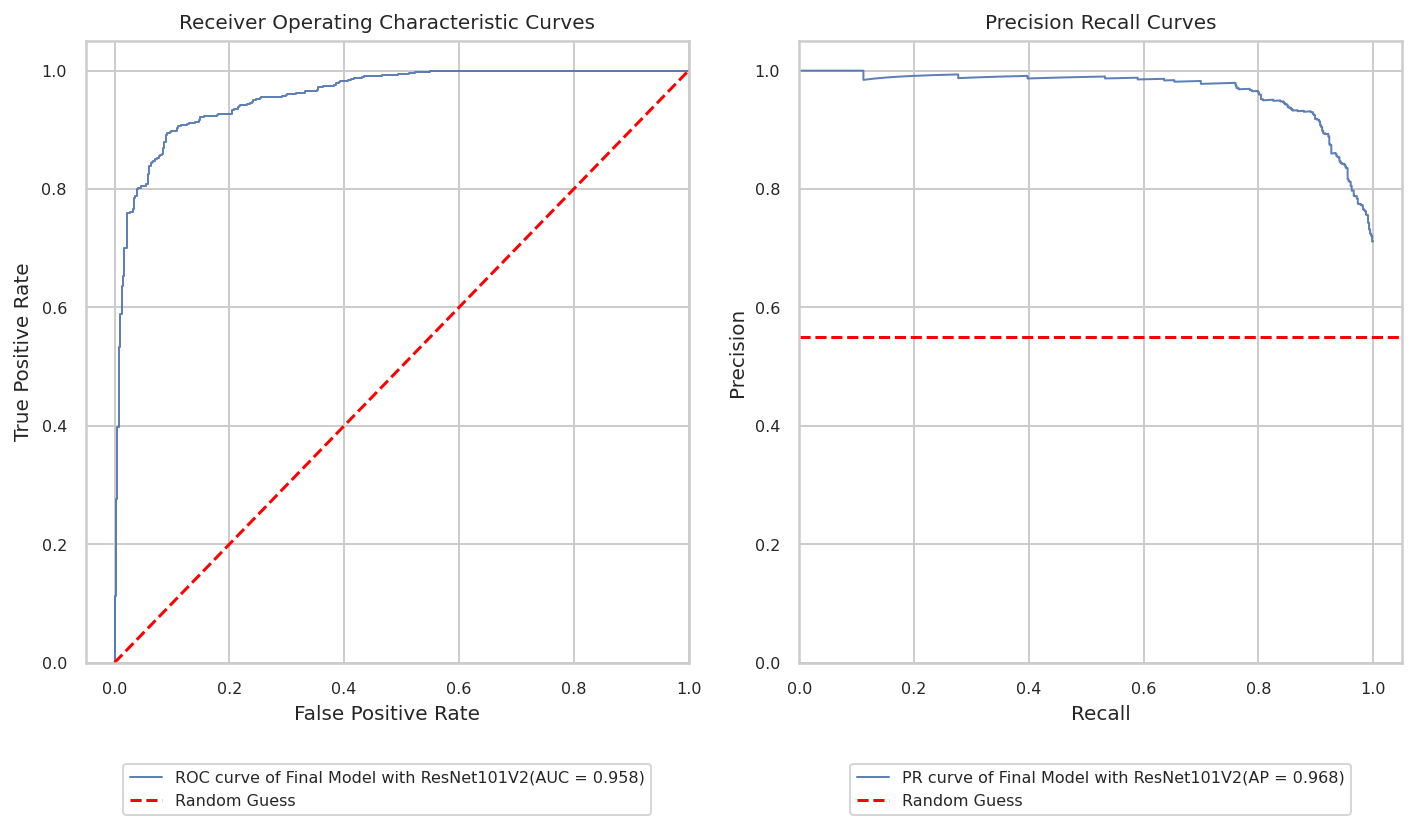

In [ ]:
# set format as retina
%config InlineBackend.figure_format = "retina"

# set theme
sns.set_theme(style="whitegrid")

# set subplots to 1*2
fig, axs = plt.subplots(1, 2, figsize=(10,6))

# ROC curves
for i in range(len(models)):
    k = models[i]
    axs[0].plot(
          fpr_dict[k],
          tpr_dict[k],
          label="ROC curve of {}(AUC = {:.3f})".format(k, auc_dict[k]),
          lw = 1,
          alpha = 0.9
    )

# PR curves
# reference line
axs[0].plot([0, 1], [0, 1],
        linestyle="dashed",
        lw=1.5,
        color="red",
        label="Random Guess")

axs[0].set_title("Receiver Operating Characteristic Curves", fontsize = 10)

axs[0].set_xlabel("False Positive Rate", fontsize = 10)
axs[0].set_ylabel("True Positive Rate", fontsize = 10)

axs[0].set_xlim(-0.05, 1)
axs[0].set_ylim(0, 1.05)

# PR curve for each model
for i in range(len(models)):
    k = models[i]
    axs[1].plot(
            rc_dict[k],
            pc_dict[k],
            label="PR curve of {}(AP = {:.3f})".format(k, ap_dict[k]),
            lw = 1,
            alpha = 0.9
    )


# reference line
axs[1].axhline(y = np.sum(y_val) / len(y_val),
        linestyle="dashed",
        lw=1.5,
        color="red",
        label="Random Guess")

axs[1].set_title("Precision Recall Curves", fontsize = 10)

axs[1].set_xlabel("Recall", fontsize = 10)
axs[1].set_ylabel("Precision", fontsize = 10)

axs[1].set_xlim(0, 1.05)
axs[1].set_ylim(0, 1.05)

for j in range(2):
    axs[j].tick_params(labelsize=8)
        
    legend = axs[j].legend(prop={'size': 8},
                           loc="upper center", bbox_to_anchor=(0.5, -0.15))

# use tight layout to save space
plt.tight_layout()

plt.show()

##4. Experiments

In [ ]:
def transfer_prefetch(X, y):
    """Transfer np.array to tfds

    Args:
        X (np.array): numpy array for predictors
        y (np.array): numpy array for the response variable

    Returns:
        tfds: tfds object for X and y
    """
    train_tfds = tf.data.Dataset.from_tensor_slices(
        (tf.convert_to_tensor(X), tf.convert_to_tensor(y))
    )
    train_tfds = train_tfds.cache().batch(32).prefetch(buffer_size=10)
    return train_tfds


Experiment 1: Held-one-out experiment for different subgroups. Details were introduced in slides and the report.

In [ ]:
auc_exp, ap_exp = [], []
for r in range(4):
    X_exp_train = data_exp_r[r]["train"]["X"]
    y_exp_train = data_exp_r[r]["train"]["y"]

    X_exp_val = data_exp_r[r]["val"]["X"]
    y_exp_val = data_exp_r[r]["val"]["y"]

    X_exp_test = data_exp_r[r]["test"]["X"]
    y_exp_test = data_exp_r[r]["test"]["y"]

    print(X_exp_train.shape)

    tfds_exp_train = transfer_prefetch(X_exp_train, y_exp_train)
    tfds_exp_val = transfer_prefetch(X_exp_val, y_exp_val)

    # training
    model = buiding_and_tuning_model(
        tfds_exp_train, tfds_exp_val, 0.1, epochs_top=20, epochs_finetuning=10
    )

    # evaluation
    auc_temp, ap_temp = [], []
    for t in range(4):
        X_exp_test_sub = X_exp_test[t]
        y_exp_test_sub = y_exp_test[t]
        tfds_exp_test = transfer_prefetch(X_exp_test_sub, y_exp_test_sub)
        y_test_prob, auc, ap = model_evl(model, tfds_exp_test, y_exp_test_sub, True)
        auc_temp.append(auc)
        ap_temp.append(ap)
    auc_exp.append(auc_temp)
    ap_exp.append(ap_temp)


(3594, 200, 200, 3)
171327488/171317808 [==============================] - 3s 0us/step
Epoch 1/20
113/113 [==============================] - 37s 174ms/step - loss: 0.6042 - binary_accuracy: 0.6644 - val_loss: 0.5132 - val_binary_accuracy: 0.7215
Epoch 2/20
113/113 [==============================] - 17s 153ms/step - loss: 0.5482 - binary_accuracy: 0.7042 - val_loss: 0.5052 - val_binary_accuracy: 0.7083
Epoch 3/20
113/113 [==============================] - 17s 154ms/step - loss: 0.5196 - binary_accuracy: 0.7293 - val_loss: 0.4838 - val_binary_accuracy: 0.7259
Epoch 4/20
113/113 [==============================] - 18s 156ms/step - loss: 0.5144 - binary_accuracy: 0.7290 - val_loss: 0.4825 - val_binary_accuracy: 0.7325
Epoch 5/20
113/113 [==============================] - 18s 158ms/step - loss: 0.5084 - binary_accuracy: 0.7298 - val_loss: 0.4544 - val_binary_accuracy: 0.7500
Epoch 6/20
113/113 [==============================] - 18s 159ms/step - loss: 0.4870 - binary_accuracy: 0.7499 - val_lo

Experiment 2: Imbalanced data (80%, 20%). Details were introduced in slides and the report.

In [ ]:
auc_exp2, ap_exp2, models_exp = [], [], []
for r in range(2):
    X_exp_train = data_exp_g[r]["train"]["X"]
    y_exp_train = data_exp_g[r]["train"]["y"]

    X_exp_val = data_exp_g[r]["val"]["X"]
    y_exp_val = data_exp_g[r]["val"]["y"]

    X_exp_test = data_exp_g[r]["test"]["X"]
    y_exp_test = data_exp_g[r]["test"]["y"]

    # print(X_exp_train.shape)

    tfds_exp_train = transfer_prefetch(X_exp_train, y_exp_train)
    tfds_exp_val = transfer_prefetch(X_exp_val, y_exp_val)

    # training
    model = buiding_and_tuning_model(
        tfds_exp_train, tfds_exp_val, 0.1, epochs_top=20, epochs_finetuning=10
    )
    models_exp.append(model)

    # evaluation
    auc_temp, ap_temp = [], []
    for t in range(2):
        X_exp_test_sub = data_exp_g[t]["test"]["X"]
        y_exp_test_sub = data_exp_g[t]["test"]["y"]
        tfds_exp_test = transfer_prefetch(X_exp_test_sub, y_exp_test_sub)
        prob, auc, ap = model_evl(model, tfds_exp_test, y_exp_test_sub, True)
        auc_temp.append(auc)
        ap_temp.append(ap)
    auc_exp2.append(auc_temp)
    ap_exp2.append(ap_temp)


Epoch 1/20
69/69 [==============================] - 19s 192ms/step - loss: 0.9521 - binary_accuracy: 0.7932 - val_loss: 1.8544 - val_binary_accuracy: 0.2109
Epoch 2/20
69/69 [==============================] - 11s 161ms/step - loss: 1.4135 - binary_accuracy: 0.6205 - val_loss: 0.8523 - val_binary_accuracy: 0.6509
Epoch 3/20
69/69 [==============================] - 11s 162ms/step - loss: 1.0342 - binary_accuracy: 0.6683 - val_loss: 0.9127 - val_binary_accuracy: 0.5855
Epoch 4/20
69/69 [==============================] - 11s 161ms/step - loss: 0.9764 - binary_accuracy: 0.6802 - val_loss: 0.7641 - val_binary_accuracy: 0.6618
Epoch 5/20
69/69 [==============================] - 11s 160ms/step - loss: 0.8912 - binary_accuracy: 0.6952 - val_loss: 0.6946 - val_binary_accuracy: 0.7200
Epoch 6/20
69/69 [==============================] - 11s 159ms/step - loss: 0.8397 - binary_accuracy: 0.7189 - val_loss: 0.6521 - val_binary_accuracy: 0.7455
Epoch 7/20
69/69 [==============================] - 11s 15

Visualization for the ROC and PR curves for the experiment.

In [ ]:
y_test_prob, auc_list, ap_list = [], [], []

# calculate and store the output, auc, ap
for i in range(2):
    model = models_exp[i]

    X_exp_test_sub = data_exp_g[1]["test"]["X"]
    y_exp_test_sub = data_exp_g[1]["test"]["y"]
    tfds_exp_test = transfer_prefetch(X_rgb_test, y_test)

    prob, auc, ap = model_evl(model, tfds_exp_test, y_test, True)

    y_test_prob.append(prob)
    auc_list.append(auc)
    ap_list.append(ap)


The AUC is 0.67286
The AP is 0.73619
The AUC is 0.71130
The AP is 0.77782


In [ ]:
# init variables for visualization
models = ["80% Male + 20% Female", "80% Female + 20% Male"]
fpr_dict, tpr_dict = dict(), dict()
pc_dict, rc_dict = dict(), dict()
auc_dict, ap_dict = dict(), dict()

# store the values for plotting
for i in range(2):
    fpr, tpr, thresholds = metrics.roc_curve(data_exp_g[i]["test"]["y"], y_test_prob[i])
    pc, rc, thresholds = precision_recall_curve(
        data_exp_g[i]["test"]["y"], y_test_prob[i]
    )

    fpr_dict[models[i]] = fpr
    tpr_dict[models[i]] = tpr
    pc_dict[models[i]] = pc
    rc_dict[models[i]] = rc

    auc_dict[models[i]] = auc_list[i]
    ap_dict[models[i]] = ap_list[i]


Plot the ROC and PR curves.

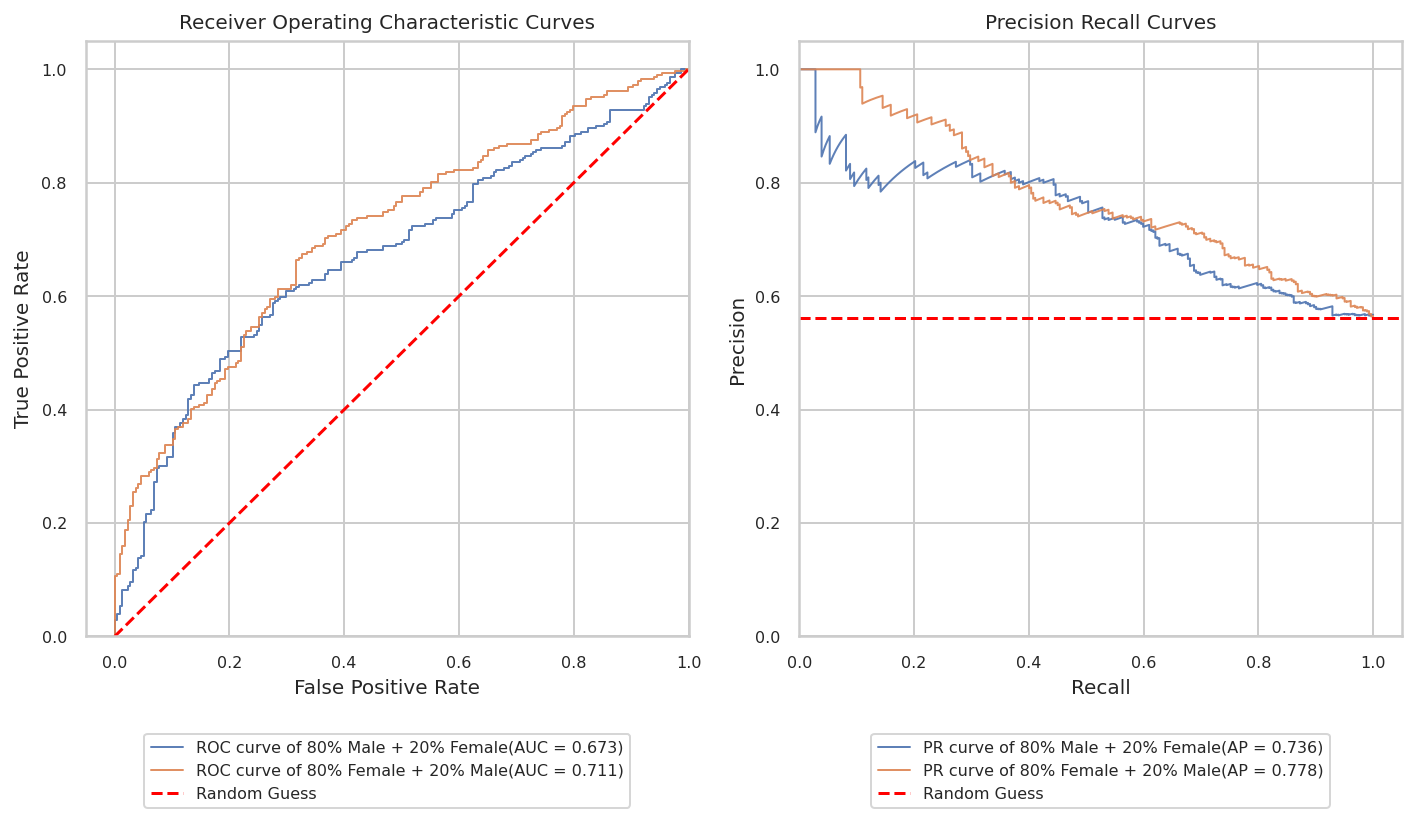

In [ ]:
# set format as retina
%config InlineBackend.figure_format = "retina"

# set theme
sns.set_theme(style="whitegrid")

# set subplots to 1*2
fig, axs = plt.subplots(1, 2, figsize=(10,6))

# ROC curves
for i in range(len(models)):
    k = models[i]
    axs[0].plot(
          fpr_dict[k],
          tpr_dict[k],
          label="ROC curve of {}(AUC = {:.3f})".format(k, auc_dict[k]),
          lw = 1,
          alpha = 0.9
    )

# PR curves
# reference line
axs[0].plot([0, 1], [0, 1],
        linestyle="dashed",
        lw=1.5,
        color="red",
        label="Random Guess")

axs[0].set_title("Receiver Operating Characteristic Curves", fontsize = 10)

axs[0].set_xlabel("False Positive Rate", fontsize = 10)
axs[0].set_ylabel("True Positive Rate", fontsize = 10)

axs[0].set_xlim(-0.05, 1)
axs[0].set_ylim(0, 1.05)

# PR curve for each model
for i in range(len(models)):
    k = models[i]
    axs[1].plot(
            rc_dict[k],
            pc_dict[k],
            label="PR curve of {}(AP = {:.3f})".format(k, ap_dict[k]),
            lw = 1,
            alpha = 0.9
    )


# reference line
axs[1].axhline(y = np.sum(y_val) / len(y_val),
        linestyle="dashed",
        lw=1.5,
        color="red",
        label="Random Guess")

axs[1].set_title("Precision Recall Curves", fontsize = 10)

axs[1].set_xlabel("Recall", fontsize = 10)
axs[1].set_ylabel("Precision", fontsize = 10)

axs[1].set_xlim(0, 1.05)
axs[1].set_ylim(0, 1.05)

for j in range(2):
    axs[j].tick_params(labelsize=8)
        
    legend = axs[j].legend(prop={'size': 8},
                           loc="upper center", bbox_to_anchor=(0.5, -0.15))

# use tight layout to save space
plt.tight_layout()

plt.show()